# Sentiment Analysis
Sentiment analysis using long short-term memory classifier
* LSTM model
* LSTM with class weights model

## Import and install required libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors, Word2Vec
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
import time
from sklearn.utils import class_weight
from keras.initializers import Constant

In [ ]:
gpus = tf.config.list_physical_devices('GPU')

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.config.experimental.set_memory_growth(gpus[0], True)

## Read dataset

In [ ]:
train_data = pd.read_csv('../dataset/train_aug.csv')
test_data = pd.read_csv('../dataset/test.csv')
full_dataset_df = pd.read_csv('../dataset/full_dataset_final.csv')

## Word embeddings

In [ ]:
# represents how big your dimensional size of your word2vec
W2V_SIZE = 300 

# Window_Size refers to the number of words on either side of a target word that are used to predict the target word
W2V_WINDOW = 2 

# Number of epochs to train the word2vec
W2V_EPOCH = 32 

# This mean that, if the word that occurs less than 2 times, will be drop away from the dictionary
W2V_MIN_COUNT = 2 

word2vec_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [ ]:
tokens = [word_tokenize(text) for text in train_data["clean_text"]]

In [ ]:
word2vec_model.build_vocab(tokens)

In [ ]:
X_train, x_val, Y_train, y_val = train_test_split(train_data['clean_text'], train_data['manual_label'], test_size=0.2, stratify=train_data['manual_label'], random_state=42)
x_test, y_test = test_data['clean_text'].to_numpy(), test_data['manual_label'].to_numpy()
X_full_dataset, Y_full_dataset = full_dataset_df['clean_text'].to_numpy(), [0]*full_dataset_df.shape[0]

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_data['clean_text'])

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
# Creating the embedding layer based on the vocab size, Word2Vec Size, weights of the matrix as well length of the text
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=max_len)

## LSTM model

In [ ]:
num_classes = 3

def model_LSTM():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(128, dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Callbacks to incurr early-stopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                  EarlyStopping(monitor='val_accuracy', min_delta=1e-8, patience=5)]

In [ ]:
# A helper function for creating Confusion Matrix and displaying the report
def Confusion_Matrix(y_true, y_pred, labels, title):
    
    # Create a confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for {}".format(title))
    
    print(f"Classification Report:\n\n",classification_report(y_true, y_pred))
    print("-"*100)
    # plt.savefig("visualizations/Confusion Matrix for "+title+ " fold "+str(fold_count)+".jpg")
    plt.show()

In [ ]:
# Pad the sequences to make all the same == maxlength
# By right when we doing padding our sequences, the maxlen argument must be greater or equal maxlen of the longest in text
padded_X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
padded_X_val = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=max_len)
padded_X_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len)
padded_X_full_dataset = pad_sequences(tokenizer.texts_to_sequences(X_full_dataset), maxlen=max_len)

In [ ]:
history = {}
    
le = LabelEncoder()

# label encoding for our categorical variable
y_train = le.fit_transform(Y_train)
y_val = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes)

LSTM_model = model_LSTM()
start = time.time()
history["imbalanced_model"] = LSTM_model.fit(padded_X_train, y_train,
            batch_size=32,
            epochs=30,
            validation_data=(padded_X_val, y_val),
            verbose=1,
            callbacks=callbacks)
end = time.time()
print("Training time: {:.3f}".format(end-start))
LSTM_model.save('LSTM_balanced_model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 300)          1424100   
                                                                 
 dropout (Dropout)           (None, 265, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,644,135
Trainable params: 1,644,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
56/56 [==============================] - 7s 47ms/step - loss: 1.0652 - accuracy: 0.4960 - val_loss: 0.9872 - val_accuracy: 0.4955 - lr: 1.0000e-04
Epoch 2/30
56/56 [==

INFO:tensorflow:Assets written to: LSTM_balanced_model\assets


INFO:tensorflow:Assets written to: LSTM_balanced_model\assets


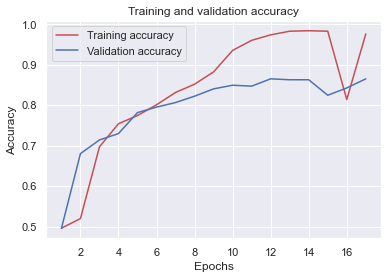

In [ ]:
train_acc = history["imbalanced_model"].history['accuracy']
val_acc = history["imbalanced_model"].history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
# plot the data
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

13/13 [==============================] - 1s 22ms/step
Classification Report:

               precision    recall  f1-score   support

         neg       0.55      0.52      0.54        21
         neu       0.63      0.73      0.67       102
         pos       0.90      0.86      0.88       277

    accuracy                           0.81       400
   macro avg       0.69      0.70      0.70       400
weighted avg       0.82      0.81      0.81       400

----------------------------------------------------------------------------------------------------


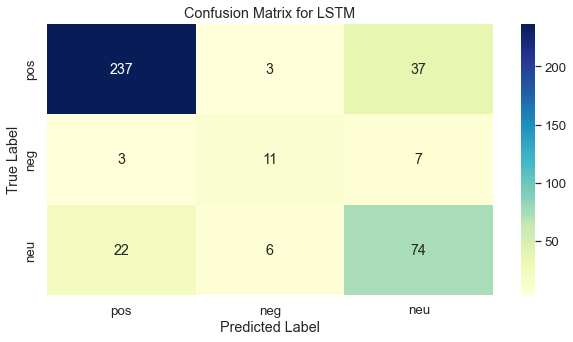

Evaluation time on test dataset: 0.850


In [ ]:
start = time.time()
y_pred = LSTM_model.predict(padded_X_test)
end = time.time()
y_pred = np.argmax(y_pred, axis=1)
y_pred_labels = le.inverse_transform(y_pred)

y_test_labels = np.argmax(y_test_encoded, axis=1)
y_test_labels = le.inverse_transform(y_test_labels)


Confusion_Matrix(y_test_labels, y_pred_labels, ["pos", "neg", "neu"], "LSTM")
print("Evaluation time on test dataset: {:.3f}".format(end-start))

## LSTM with class weights model

In [ ]:
num_classes = 3

def model_LSTM_bias(bias):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(128, dropout=0.2))
    model.add(Dense(num_classes, activation='softmax',bias_initializer=bias))
    model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Callbacks to incurr early-stopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=20, cooldown=0),
                  EarlyStopping(monitor='val_accuracy', min_delta=1e-8, patience=20)]

In [ ]:
# A helper function for creating Confusion Matrix and displaying the report
def Confusion_Matrix(y_true, y_pred, labels, title):
    
    # Create a confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for {}".format(title))
    
    print(f"Classification Report:\n\n",classification_report(y_true, y_pred))
    print("-"*100)
    # plt.savefig("visualizations/Confusion Matrix for "+title+ " fold "+str(fold_count)+".jpg")
    plt.show()

In [ ]:
# Pad the sequences to make all the same == maxlength
# By right when we doing padding our sequences, the maxlen argument must be greater or equal maxlen of the longest in text
padded_X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
padded_X_val = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=max_len)
padded_X_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len)
padded_X_full_dataset = pad_sequences(tokenizer.texts_to_sequences(X_full_dataset), maxlen=max_len)

In [ ]:
history = {}   
le = LabelEncoder()

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                classes = np.unique(Y_train),
                                                y = Y_train)
class_weights = dict(enumerate(class_weights))
  

# label encoding for our categorical variable
y_train = le.fit_transform(Y_train)
y_val = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Bias
inverse_class_freq = np.zeros(num_classes)
for i in range(num_classes):
   
    class_count = np.sum(y_train==i)

    inverse_class_freq[i] = 1.0 / class_count if class_count > 0 else 0.0
bias = inverse_class_freq / sum(inverse_class_freq)     

# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes)

LSTM_model = model_LSTM_bias(Constant(value=bias))

start = time.time()
history["class_weights"] = LSTM_model.fit(padded_X_train, y_train,
            batch_size=32,
            epochs=100,
            validation_data=(padded_X_val, y_val),
            verbose=1,
            callbacks=callbacks, class_weight = class_weights)
end = time.time()
print("Training time: {:.3f}".format(end-start))
LSTM_model.save('LSTM_class_weights_model')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 300)          1424100   
                                                                 
 dropout (Dropout)           (None, 265, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,644,135
Trainable params: 1,644,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 7s 45ms/step - loss: 1.0966 - accuracy: 0.1874 - val_loss: 1.0961 - val_accuracy: 0.1869 - lr: 1.0000e-04
Epoch 2/100
56/56 [

INFO:tensorflow:Assets written to: LSTM_class_weights_model\assets


INFO:tensorflow:Assets written to: LSTM_class_weights_model\assets


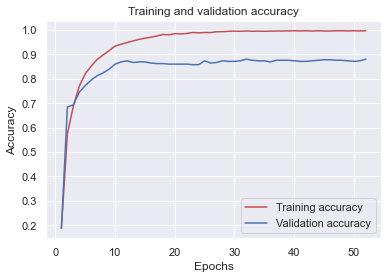

In [ ]:
train_acc = history["class_weights"].history['accuracy']
val_acc = history["class_weights"].history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
# plot the data
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

13/13 [==============================] - 1s 21ms/step
Classification Report:

               precision    recall  f1-score   support

         neg       0.57      0.38      0.46        21
         neu       0.60      0.76      0.67       102
         pos       0.90      0.83      0.87       277

    accuracy                           0.79       400
   macro avg       0.69      0.66      0.67       400
weighted avg       0.81      0.79      0.80       400

----------------------------------------------------------------------------------------------------


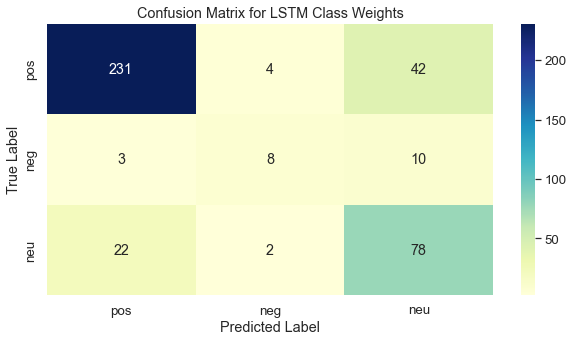

Evaluation time on test dataset: 0.760


In [ ]:
start = time.time()
y_pred = LSTM_model.predict(padded_X_test)
end = time.time()
y_pred = np.argmax(y_pred, axis=1)
y_pred_labels = le.inverse_transform(y_pred)

y_test_labels = np.argmax(y_test_encoded, axis=1)
y_test_labels = le.inverse_transform(y_test_labels)

Confusion_Matrix(y_test_labels, y_pred_labels, ["pos", "neg", "neu"], "LSTM Class Weights")
print("Evaluation time on test dataset: {:.3f}".format(end-start))

## Apply on full dataset

In [ ]:
start = time.time()
y_full_dataset_pred = LSTM_model.predict(padded_X_full_dataset)
end = time.time()
y_full_dataset_pred = np.argmax(y_full_dataset_pred, axis=1)
y_full_dataset_pred_labels = le.inverse_transform(y_full_dataset_pred)
print("Time taken for predictions on full dataset: {:.3f}".format(end-start))

635/635 [==============================] - 8s 13ms/step
Time taken for predictions on full dataset: 8.954


In [4]:
counts = full_dataset_df['LSTM Predictions'].value_counts()

counts

pos    13197
neu     6128
neg      970
Name: LSTM Predictions, dtype: int64

<Axes: >

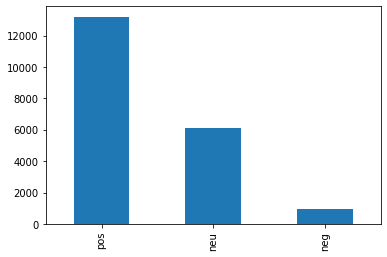

In [5]:
full_dataset_df['LSTM Predictions'].value_counts().plot.bar()

In [ ]:
full_dataset_df['LSTM Predictions'] = y_full_dataset_pred_labels
full_dataset_df.to_csv('../dataset/LSTM_full_dataset_final.csv', index=False)